# Collect Data and Train SVGP - Retraining

## Gaussian Processes

In [1]:

import torch
import gpytorch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np


import os
# libiomp5md.dll, but found libiomp5md.dll already initialized. PROBLEM with OpenMP runtime!
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # UNSAFE workaround, only used for experimentation.

import torch
import gpytorch
from torch.utils.data import TensorDataset, DataLoader


# ============================================================
# ---- Sparse GP model (SVGP con inducing points) ------------
# ============================================================
class SparseGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel='RBF', ard_dims=None):
        """
        inducing_points: tensor [M, D] ya en el device correcto
        """
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=inducing_points.size(0)
        )

        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,
        )

        super().__init__(variational_strategy)

        # Mean
        self.mean_module = gpytorch.means.ConstantMean()

        # Kernel
        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        elif kernel == 'Matern':
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)
        elif kernel == 'RQ':
            base_kernel = gpytorch.kernels.RationalQuadraticKernel(ard_num_dims=ard_dims)
        else:
            raise ValueError(f"Unsupported kernel type: {kernel}")

        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



# ============================================================
# ---- Online Sparse GP Manager ------------------------------
# ============================================================

class OnlineSparseGPManager:
    def __init__(
        self,
        kernel='RBF',
        lr=0.01,
        iters=1000,
        num_inducing=64,
        batch_size=128,
        device=None,
    ):
        """
        Online GP basado en SVGP (Sparse Variational GP).
        - kernel: 'RBF', 'Matern', 'RQ'
        - lr: learning rate Adam
        - iters: nº máximo de steps de entrenamiento "full" en fit()
        - num_inducing: nº de inducing points M
        - batch_size: tamaño de minibatch para VI
        - device: 'cuda' o 'cpu'
        """
        self.kernel = kernel
        self.lr = lr
        self.iters = iters
        self.num_inducing = num_inducing
        self.batch_size = batch_size
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        # Datos en escala original
        self.X = None      # [N, D]
        self.Y = None      # [N]

        # Datos normalizados
        self.Xn = None     # [N, D]
        self.Yn = None     # [N]

        # Normalización (fijamos tras el primer fit)
        self.X_mean = None
        self.X_std = None
        self.Y_mean = None
        self.Y_std = None

        # Modelo SVGP + likelihood
        self.likelihood = None
        self.model = None
        self.mll = None

        self.trained = False


    # ----------------------------- #
    #        FIT / INITIAL TRAIN    #
    # ----------------------------- #
    def fit(self, X, Y):
        """
        Entrenamiento inicial con todos los datos pasados.
        X: array/tensor [N, D]
        Y: array/tensor [N] o [N, 1]
        """
        # Convertir a tensores en device
        X = torch.as_tensor(X, dtype=torch.float32, device=self.device)
        Y = torch.as_tensor(Y, dtype=torch.float32, device=self.device).flatten()

        self.X = X.clone()
        self.Y = Y.clone()

        # Normalización (la fijamos aquí para todo el online)
        self._compute_normalization(initial=True)

        # Inicializar modelo SVGP + likelihood
        self._init_model()

        # Entrenar varias iteraciones (full training)
        self._train(max_steps=self.iters)

        self.trained = True


    # ----------------------------- #
    #       ADD NEW DATA POINTS     #
    # ----------------------------- #
    def add_data(self, X_new, Y_new, retrain=True, online_steps=50):
        """
        Añadir nuevos datos (online) y entrenar unas pocas steps.
        X_new: [N_new, D]
        Y_new: [N_new]
        online_steps: nº de steps de optimización tras añadir datos
                      (típicamente << self.iters)
        """
        # Convertir a tensores
        X_new = torch.as_tensor(X_new, dtype=torch.float32, device=self.device)
        Y_new = torch.as_tensor(Y_new, dtype=torch.float32, device=self.device).flatten()

        if self.X is None or self.Y is None:
            # Si no había datos, esto equivale a fit()
            self.fit(X_new, Y_new)
            return

        # Apilar a dataset existente (escala original)
        self.X = torch.cat([self.X, X_new], dim=0)
        self.Y = torch.cat([self.Y, Y_new], dim=0)

        # ✅ Importante: mantenemos la normalización ORIGINAL
        # para no romper el modelo. Solo normalizamos los nuevos
        # datos con las mismas X_mean, X_std, etc.
        self._update_normalized_data()

        # Actualizar num_data del ELBO
        self.mll.num_data = self.Yn.size(0)

        if retrain:
            # Entrenamiento "ligero" online (unas pocas steps)
            self._train(max_steps=online_steps)


    # ----------------------------- #
    #         INTERNAL UTILS        #
    # ----------------------------- #
    def _compute_normalization(self, initial=False):
        """
        Calcula X_mean, X_std, Y_mean, Y_std a partir de self.X, self.Y.
        Si initial=True se fijan para todo el proceso online.
        """
        if initial or self.X_mean is None:
            self.X_mean = self.X.mean(dim=0)
            self.X_std = self.X.std(dim=0) + 1e-8
            self.Y_mean = self.Y.mean(dim=0)
            self.Y_std = self.Y.std(dim=0) + 1e-8

        # Normalización usando SIEMPRE las mismas medias/varianzas
        self.Xn = (self.X - self.X_mean) / self.X_std
        self.Yn = (self.Y - self.Y_mean) / self.Y_std

    def _update_normalized_data(self):
        """
        Recalcula Xn, Yn con los mismos X_mean, X_std, Y_mean, Y_std
        (no se vuelven a estimar, solo se aplican a los nuevos datos).
        """
        self.Xn = (self.X - self.X_mean) / self.X_std
        self.Yn = (self.Y - self.Y_mean) / self.Y_std

    def dataset(self):
        """
        Devuelve los datos en escala original como numpy (para debug).
        """
        X_np = self.X.detach().cpu().numpy()
        Y_np = self.Y.detach().cpu().numpy()
        return X_np, Y_np

    def _init_model(self):
        """
        Crea el modelo SVGP + likelihood a partir de self.Xn, self.Yn.
        """
        # Elegir inducing points: subset aleatorio de Xn
        N = self.Xn.size(0)
        M = min(self.num_inducing, N)
        perm = torch.randperm(N, device=self.device)
        inducing_points = self.Xn[perm[:M]].contiguous()

        # Likelihood
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood().to(self.device)
        self.likelihood.noise_covar.initialize(noise=1e-3)

        # Modelo SVGP
        self.model = SparseGPModel(
            inducing_points=inducing_points,
            kernel=self.kernel,
            ard_dims=self.Xn.shape[-1],
        ).to(self.device)

        # ELBO variacional
        self.mll = gpytorch.mlls.VariationalELBO(
            likelihood=self.likelihood,
            model=self.model,
            num_data=self.Yn.size(0),
        )

    def _train(self, max_steps=None):
        """
        Entrenamiento variacional (SVGP) con minibatches.
        max_steps: nº máximo de pasos de optimización
        """
        if max_steps is None:
            max_steps = self.iters

        self.model.train()
        self.likelihood.train()

        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        dataset = TensorDataset(self.Xn, self.Yn)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        step = 0
        while step < max_steps:
            for Xb, Yb in loader:
                optimizer.zero_grad()
                output = self.model(Xb)
                loss = -self.mll(output, Yb)
                loss.backward()
                optimizer.step()

                step += 1
                if step >= max_steps:
                    break

        self.model.eval()
        self.likelihood.eval()
        self.trained = True


    # ----------------------------- #
    #            PREDICT            #
    # ----------------------------- #
    @torch.no_grad()
    def predict(self, X):
        """
        Predicción de media y varianza en escala ORIGINAL.
        X: [N_test, D]
        Devuelve:
          mean_np: [N_test]
          var_np:  [N_test]
        """
        if not self.trained:
            raise RuntimeError("GP has not been trained yet.")

        X = torch.as_tensor(X, dtype=torch.float32, device=self.device)
        Xn = (X - self.X_mean) / self.X_std

        with gpytorch.settings.fast_pred_var():
            pred_dist = self.likelihood(self.model(Xn))
            mean = pred_dist.mean * self.Y_std + self.Y_mean
            var = pred_dist.variance * (self.Y_std ** 2)

        return mean.detach().cpu().numpy(), var.detach().cpu().numpy()



## Recolección de datos

Using device: cuda
✅ Simulador inicializado correctamente.


Rollout MuJoCo: 100%|██████████| 100/100 [00:00<00:00, 7385.90it/s]

✅ Datos recolectados:
  states     : (100, 6)
  actions    : (100, 2)
  delta_s    : (100, 6)
✅ Dataset para GP:
  X: (25, 8)  (state+action)
  Y: (25, 6)  (delta_state)


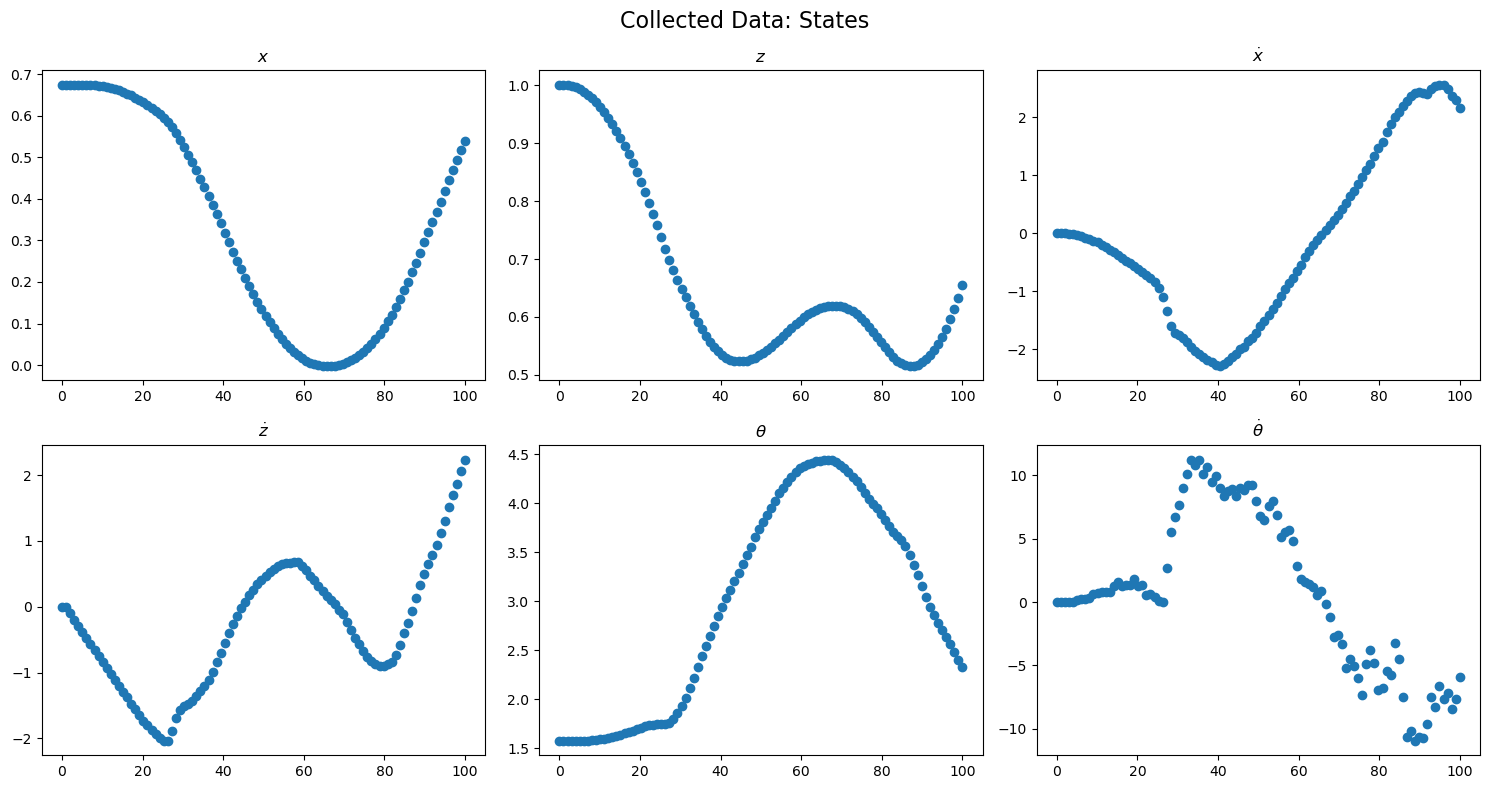

In [2]:
# ===============================================
# 1. Imports y setup MuJoCo + Torch
# ===============================================
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # solo para evitar el warning de OpenMP

import mujoco as mj
from mujoco.glfw import glfw
import numpy as np
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

from models.cantilever_2d_drone import get_xml  # tu generador XML

# Opcional: elegir device para Torch (aunque GPManager original trabaja en CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# ===============================================
# 2. Crear modelo MuJoCo a partir del XML
# ===============================================
XML = get_xml(num_segmentos=8, longitud_total=0.6)
model = mj.MjModel.from_xml_string(XML)
data = mj.MjData(model)

print("✅ Simulador inicializado correctamente.")

# ===============================================
# 3. Utilidades para ángulos y estado del dron
# ===============================================

def unwrap_angle(angle_raw, angle_prev):
    """
    Devuelve un ángulo continuo, sin saltos bruscos de ±2π.
    """
    if angle_prev is None:
        return angle_raw

    delta = angle_raw - angle_prev
    if delta > np.pi:
        angle_raw -= 2 * np.pi
    elif delta < -np.pi:
        angle_raw += 2 * np.pi
    return angle_raw


def quat_to_roll_x(quat, prev_roll=None):
    """
    Convierte cuaternión [w,x,y,z] a ángulo de roll alrededor de X,
    y lo hace continuo usando unwrap.
    """
    w, x, y, z = quat

    # roll (X)
    sinr_cosp = 2.0 * (w * x + y * z)
    cosr_cosp = 1.0 - 2.0 * (x * x + y * y)
    roll_raw = np.arctan2(sinr_cosp, cosr_cosp)

    roll_cont = unwrap_angle(roll_raw, prev_roll)
    return roll_cont


def get_state_from_sensors(data, prev_theta=None):
    """
    Construye el vector de estado:
        s = [x, z, x_dot, z_dot, theta, theta_dot]
    a partir de los sensores definidos en el XML.
    """
    # Posición global
    pos = data.sensor("pos_drone").data  # [x, y, z]
    x, z = pos[0], pos[2]

    # Velocidades lineales
    linvel = data.sensor("linvel_drone").data  # [vx, vy, vz]
    x_dot = linvel[0]
    z_dot = linvel[2]

    # Cuaternión del dron
    quat = data.sensor("quat_drone").data   # [w, x, y, z]
    roll_raw = quat_to_roll_x(quat, prev_theta)

    # Velocidad angular (rotvel_drone)
    angvel = data.sensor("rotvel_drone").data  # [wx, wy, wz]
    theta_dot = angvel[1]  # roll alrededor de 

    theta = roll_raw
    state = np.array([x, z, x_dot, z_dot, theta, theta_dot], dtype=np.float32)
    return state, theta

# ===============================================
# 4. Rollout aleatorio para recolectar datos
# ===============================================

def rollout_random(model, data, n_steps=5000):
    """
    Ejecuta el simulador con acciones aleatorias y devuelve:
        states:      [N, 6]
        actions:     [N, 2]
        next_states: [N, 6]
    """
    mj.mj_resetData(model, data)
    mj.mj_forward(model, data)

    states, actions, next_states = [], [], []
    prev_theta = None

    for step in tqdm(range(n_steps), desc="Rollout MuJoCo"):
        # Estado actual
        s_t, prev_theta = get_state_from_sensors(data, prev_theta)

        # Acción aleatoria en rango [0, 2], y la escalamos suave con el tiempo para no excitar demasiado al inicio
        scale = (step / n_steps)  # va de 0 → 1
        a_t = np.random.uniform(0.0, 2.0 * scale + 1e-3, size=2).astype(np.float32)
        data.ctrl[:] = a_t

        # Avanzar simulación un paso
        mj.mj_step(model, data)

        # Estado siguiente
        s_next, prev_theta = get_state_from_sensors(data, prev_theta)

        states.append(s_t)
        actions.append(a_t)
        next_states.append(s_next)

    states = np.stack(states, axis=0)
    actions = np.stack(actions, axis=0)
    next_states = np.stack(next_states, axis=0)

    return states, actions, next_states


# ===============================================
# 5. Recolectar datos y construir dataset (X, Y)
# ===============================================

N_STEPS = 100  # puedes jugar con este número; cuidado con GPs (O(N^3))
states, actions, next_states = rollout_random(model, data, n_steps=N_STEPS)

delta_s = next_states - states  # [N, 6]

print("✅ Datos recolectados:")
print("  states     :", states.shape)
print("  actions    :", actions.shape)
print("  delta_s    :", delta_s.shape)

# Construimos entradas X = [state, action]
X_np = np.concatenate([states, actions], axis=1).astype(np.float32)   # [N, 8]
Y_np = delta_s.astype(np.float32)                                     # [N, 6]

# Opcional: subsampling para que el GP sea manejable
SUBSAMPLE = 4  # usar cada k-ésimo dato
X_np = X_np[::SUBSAMPLE]
Y_np = Y_np[::SUBSAMPLE]

print("✅ Dataset para GP:")
print("  X:", X_np.shape, " (state+action)")
print("  Y:", Y_np.shape, " (delta_state)")


# ===============================================
# 6. Visualización de los datos recolectados
# ===============================================

rng = N_STEPS
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
labels = [r'$x$', r'$z$', r'$\dot{x}$', r'$\dot{z}$', r'$\theta$', r'$\dot{\theta}$']

for i, ax in enumerate(axes.flat):
    ax.scatter(np.linspace(0,rng,rng),states[0:rng,i])
    ax.set_title(f"{labels[i]}")

plt.suptitle("Collected Data: States", fontsize=16)
plt.tight_layout()
plt.show()


## GP Training

In [3]:
import os
import torch
import gpytorch

MODEL_DIR = "data/svgp_torch_models"
os.makedirs(MODEL_DIR, exist_ok=True)


def save_gp(gp, filepath):
    """
    Guarda:
      - estado del modelo SVGP
      - estado del likelihood
      - estadísticas de normalización
      - datos X, Y para continuar online
    """
    checkpoint = {
        "model_state": gp.model.state_dict(),
        "likelihood_state": gp.likelihood.state_dict(),
        "X_mean": gp.X_mean.detach().cpu(),
        "X_std": gp.X_std.detach().cpu(),
        "Y_mean": gp.Y_mean.detach().cpu(),
        "Y_std": gp.Y_std.detach().cpu(),
        "kernel": gp.kernel,
        "num_inducing": gp.num_inducing,
        "X": gp.X.detach().cpu(),
        "Y": gp.Y.detach().cpu(),
    }
    torch.save(checkpoint, filepath)
    print(f"💾 GP guardado en {filepath}")


def load_gp(gp, filepath):
    """
    Carga un OnlineSparseGPManager previamente guardado.
    Reconstruye:
      - modelo SVGP
      - likelihood
      - normalización
      - mll (ELBO) para seguir entrenando online
    """
    checkpoint = torch.load(filepath, map_location=gp.device)

    # Restaurar hiperparámetros básicos
    gp.kernel = checkpoint.get("kernel", gp.kernel)
    gp.num_inducing = int(checkpoint["num_inducing"])

    # Restaurar stats de normalización
    gp.X_mean = checkpoint["X_mean"].to(gp.device)
    gp.X_std = checkpoint["X_std"].to(gp.device)
    gp.Y_mean = checkpoint["Y_mean"].to(gp.device)
    gp.Y_std = checkpoint["Y_std"].to(gp.device)

    # Restaurar datos originales (para online training)
    gp.X = checkpoint["X"].to(gp.device)   # [N, D]
    gp.Y = checkpoint["Y"].to(gp.device)   # [N]

    # Recalcular datos normalizados con las mismas stats
    gp._update_normalized_data()           # usa X_mean/X_std/Y_mean/Y_std

    # Inicializar likelihood y modelo SVGP
    gp.likelihood = gpytorch.likelihoods.GaussianLikelihood().to(gp.device)
    gp.likelihood.noise_covar.initialize(noise=1e-3)

    N, D = gp.Xn.shape
    M = min(gp.num_inducing, N)

    # Dummy inducing points (se sobreescriben al cargar state_dict)
    inducing_init = torch.zeros(M, D, device=gp.device)

    gp.model = SparseGPModel(
        inducing_points=inducing_init,
        kernel=gp.kernel,
        ard_dims=D,
    ).to(gp.device)

    # Cargar pesos
    gp.model.load_state_dict(checkpoint["model_state"])
    gp.likelihood.load_state_dict(checkpoint["likelihood_state"])

    # ELBO para seguir entrenando
    gp.mll = gpytorch.mlls.VariationalELBO(
        likelihood=gp.likelihood,
        model=gp.model,
        num_data=gp.Yn.size(0),
    )

    gp.model.eval()
    gp.likelihood.eval()
    gp.trained = True

    print(f"📂 GP cargado desde {filepath}")



# ===============================================
# 6. Entrenar o cargar modelos GP (SVGP online)
# ===============================================

state_dim = Y_np.shape[1]   # 6
gps = []

device = "cuda" if torch.cuda.is_available() else "cpu"

for d in range(state_dim):
    gp_path = os.path.join(MODEL_DIR, f"svgp_dim{d}.pth")

    # Manager SVGP online para una dimensión de la dinámica
    gp = OnlineSparseGPManager(
        kernel='RBF',
        lr=0.01,
        iters=1000,        # pasos de entrenamiento inicial
        num_inducing=64,   # nº de inducing points
        batch_size=128,
        device=device,
    )

    if os.path.exists(gp_path):
        print(f"📦 Cargando GP SVGP para dimensión {d}...")
        load_gp(gp, gp_path)
    else:
        print(f"🧠 Entrenando GP SVGP para dimensión {d}...")
        gp.fit(X_np, Y_np[:, d])   # X_np: [N, 8], Y_np[:,d]: [N]
        save_gp(gp, gp_path)

    gps.append(gp)

print("🎉 Todos los GPs SVGP listos (cargados o entrenados).")



# ===============================================
# 7. Función de predicción de un paso con el modelo GP
# ===============================================

def gp_dynamics_step(gps, state, action):
    """
    Calcula s_{t+1} = s_t + Δs usando la familia de GPs.
    state:  [6]  (numpy o torch)
    action: [2]
    """
    if isinstance(state, torch.Tensor):
        state = state.detach().cpu().numpy()
    if isinstance(action, torch.Tensor):
        action = action.detach().cpu().numpy()

    x = np.concatenate([state, action], axis=-1)[None, :]  # [1, 8]
    delta_pred = []

    for d, gp in enumerate(gps):
        mean_d, _ = gp.predict(x)   # mean_d: [1]
        delta_pred.append(mean_d[0])

    delta_pred = np.array(delta_pred, dtype=np.float32)  # [6]
    next_state_pred = state + delta_pred
    return next_state_pred, delta_pred


# Ejemplo rápido de uso:
s0 = states[0]
a0 = np.array([0.5, 0.5], dtype=np.float32)
s1_pred, ds_pred = gp_dynamics_step(gps, s0, a0)
print("Estado inicial s0:", s0)
print("Acción a0        :", a0)
print("Δs (GP)          :", ds_pred)
print("s1 (GP)          :", s1_pred)


🧠 Entrenando GP SVGP para dimensión 0...
💾 GP guardado en data/svgp_torch_models\svgp_dim0.pth
🧠 Entrenando GP SVGP para dimensión 1...
💾 GP guardado en data/svgp_torch_models\svgp_dim1.pth
🧠 Entrenando GP SVGP para dimensión 2...
💾 GP guardado en data/svgp_torch_models\svgp_dim2.pth
🧠 Entrenando GP SVGP para dimensión 3...
💾 GP guardado en data/svgp_torch_models\svgp_dim3.pth
🧠 Entrenando GP SVGP para dimensión 4...
💾 GP guardado en data/svgp_torch_models\svgp_dim4.pth
🧠 Entrenando GP SVGP para dimensión 5...
💾 GP guardado en data/svgp_torch_models\svgp_dim5.pth
🎉 Todos los GPs SVGP listos (cargados o entrenados).
Estado inicial s0: [0.675     1.00125   0.        0.        1.5707964 0.       ]
Acción a0        : [0.5 0.5]
Δs (GP)          : [ 0.00159332  0.00221177 -0.00095003 -0.0485101  -0.01051415 -0.5955819 ]
s1 (GP)          : [ 6.7659330e-01  1.0034618e+00 -9.5003098e-04 -4.8510104e-02
  1.5602822e+00 -5.9558189e-01]


## Visualization

⚙️ Calculando predicciones GP (una sola vez)...
✅ Predicciones GP precomputadas.

🚀 Generando figuras de comparación compactas (2x3 por tipo)...


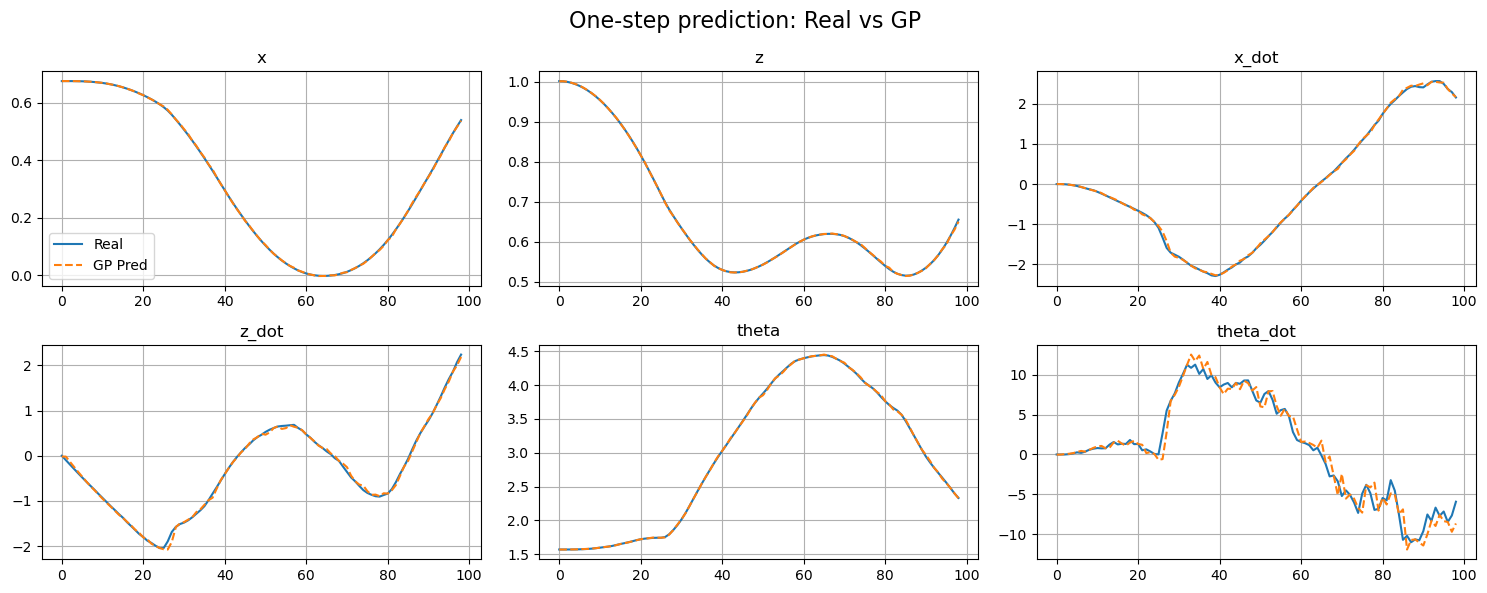

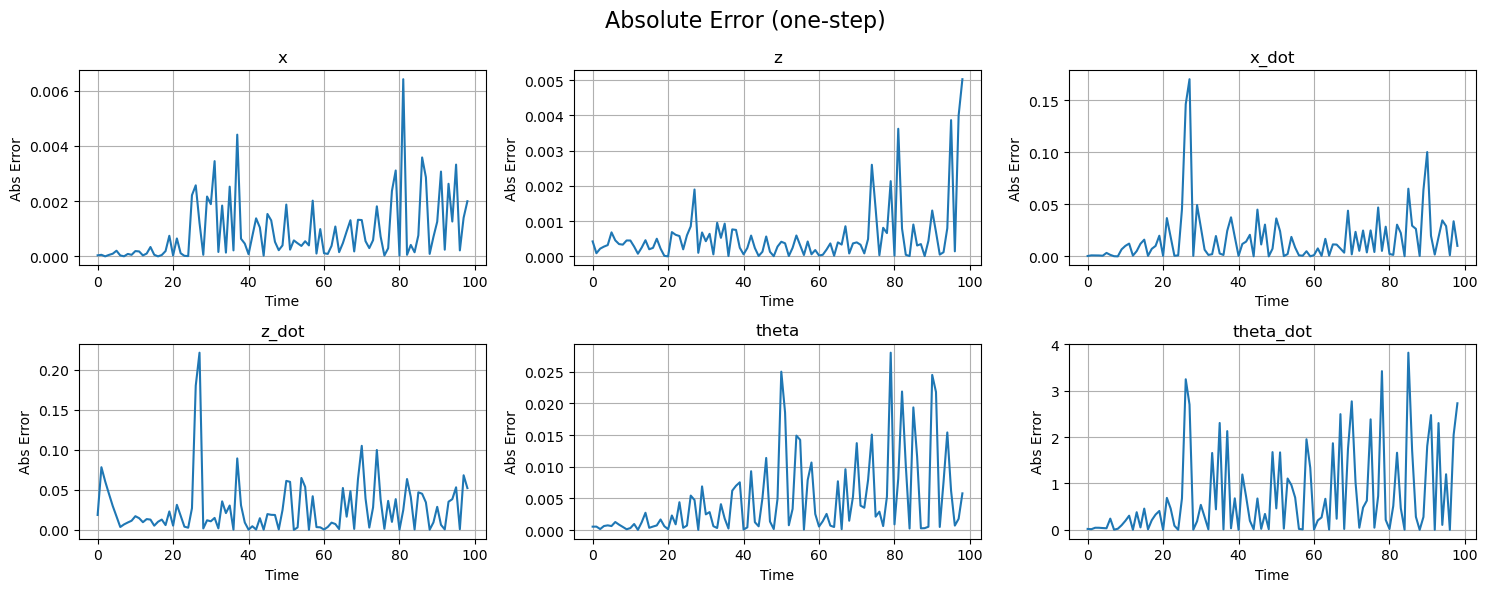

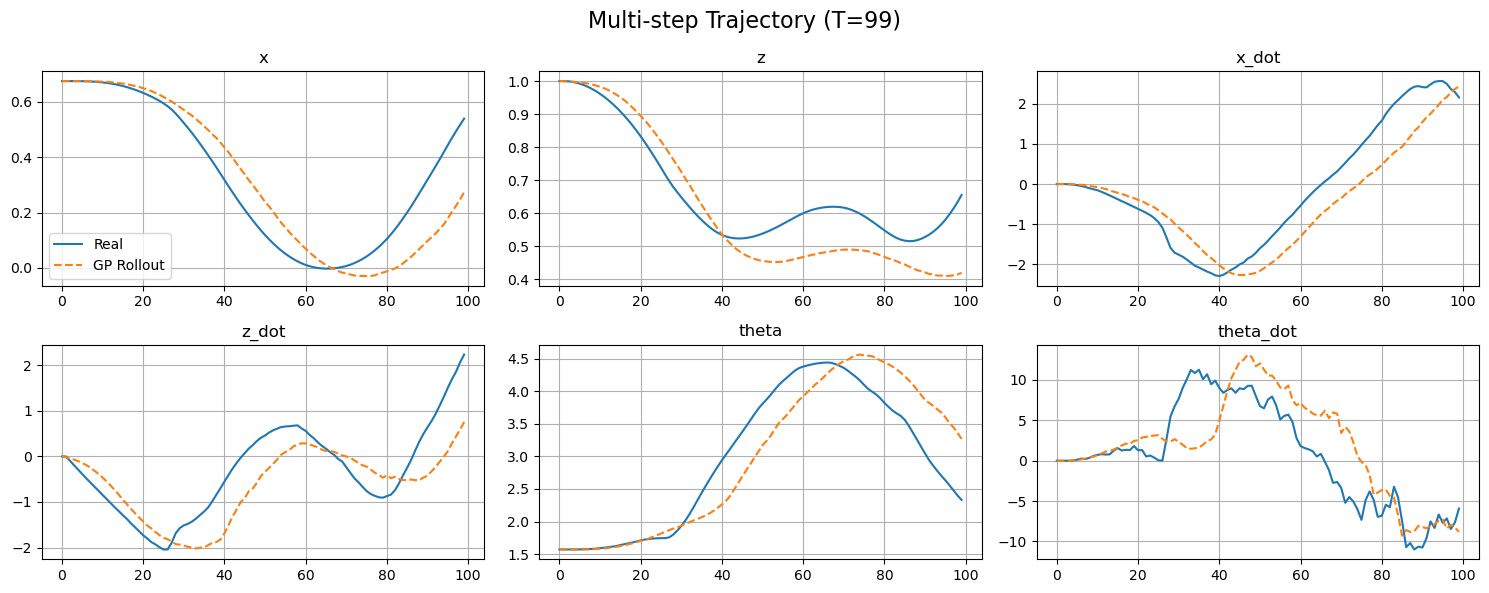

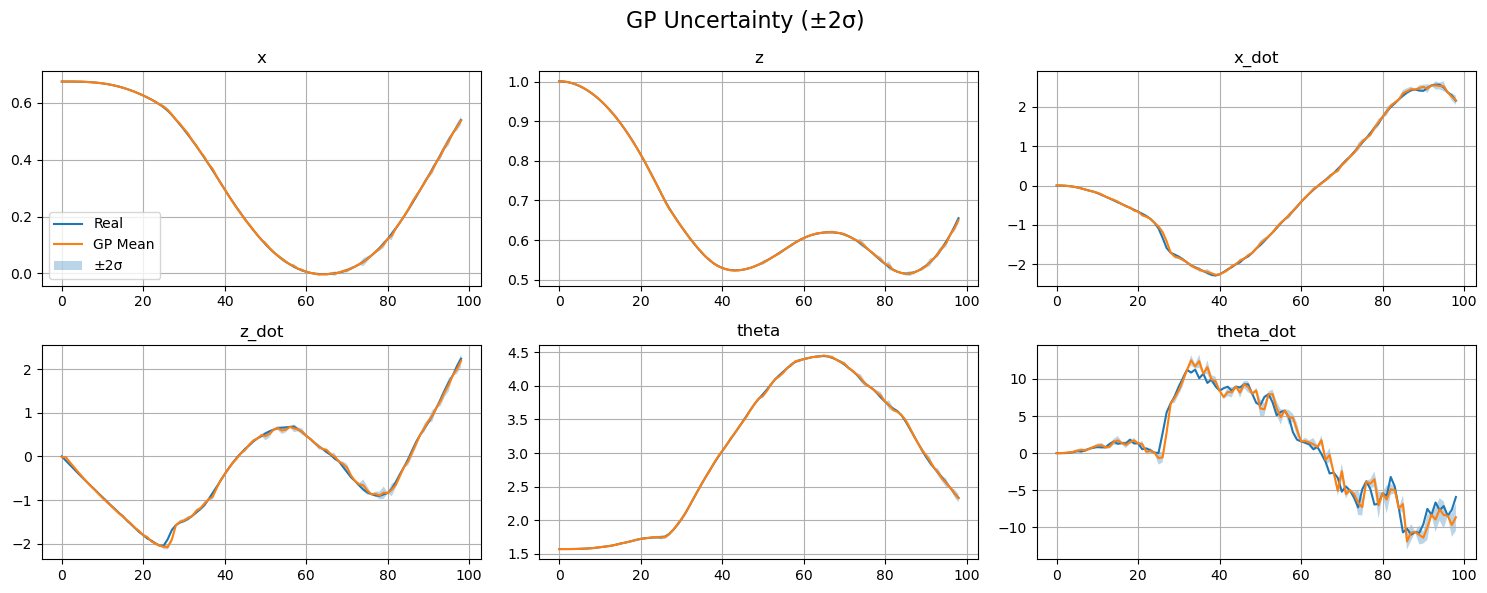


📊 MÉTRICAS DE REGRESIÓN POR DIMENSIÓN
         x | RMSE=0.001513 | MAE=0.000941 | R²=1.0000
         z | RMSE=0.001350 | MAE=0.000657 | R²=0.9999
     x_dot | RMSE=0.032478 | MAE=0.017954 | R²=0.9995
     z_dot | RMSE=0.044063 | MAE=0.027438 | R²=0.9981
     theta | RMSE=0.007945 | MAE=0.004789 | R²=0.9999
 theta_dot | RMSE=1.185435 | MAE=0.739427 | R²=0.9637


In [4]:
# ===============================================
# 8. PREDICCIONES GP PRECOMPUTADAS (UNA SOLA VEZ)
# ===============================================
import numpy as np
import matplotlib.pyplot as plt

DIM_LABELS = ["x", "z", "x_dot", "z_dot", "theta", "theta_dot"]

N, state_dim = states.shape

# Construir X_all = [state, action] para TODO el dataset
X_all = np.concatenate([states, actions], axis=1).astype(np.float32)   # [N, 8]

# mean_delta_all[d]: Δs_pred_dim_d, var_delta_all[d]: var(Δs_dim_d)
mean_delta_all = np.zeros((N, state_dim), dtype=np.float32)
var_delta_all  = np.zeros((N, state_dim), dtype=np.float32)

print("⚙️ Calculando predicciones GP (una sola vez)...")
for d, gp in enumerate(gps):
    m, v = gp.predict(X_all)          # m, v: [N]
    mean_delta_all[:, d] = m
    var_delta_all[:, d]  = v

# Predicción one-step del siguiente estado:
s_pred_all   = states + mean_delta_all           # [N, 6]  → s_{t+1}^{pred}
std_next_all = np.sqrt(var_delta_all)            # desv. estándar de s_{t+1}
print("✅ Predicciones GP precomputadas.")

# Parámetros de horizonte
ONE_STEP_T = 400      # pasos para one-step
ERROR_T    = 400      # pasos para error absoluto
TRAJ_T     = 100      # pasos multi-step rollout
UNC_T      = 100      # pasos para incertidumbre


# ===============================================
# 9. GRÁFICAS COMPACTAS (2x3) USANDO ARRAYS PRECOMPUTADOS
# ===============================================

# -----------------------------
# 9.1 One-step: Real vs GP
# -----------------------------
def plot_one_step_grid(next_states, s_pred_all, T=ONE_STEP_T):
    T = min(T, len(next_states)-1)
    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()

    for d in range(6):
        ax = axes[d]
        ax.plot(next_states[:T, d], label="Real")
        ax.plot(s_pred_all[:T, d], '--', label="GP Pred")
        ax.set_title(DIM_LABELS[d])
        ax.grid(True)
        if d == 0:
            ax.legend()

    fig.suptitle("One-step prediction: Real vs GP", fontsize=16)
    plt.tight_layout()
    plt.show()


# -----------------------------
# 9.2 Error absoluto
# -----------------------------
def plot_abs_error_grid(next_states, s_pred_all, T=ERROR_T):
    T = min(T, len(next_states)-1)
    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()

    abs_err = np.abs(next_states - s_pred_all)   # [N, 6]

    for d in range(6):
        ax = axes[d]
        ax.plot(abs_err[:T, d])
        ax.set_title(DIM_LABELS[d])
        ax.set_xlabel("Time")
        ax.set_ylabel("Abs Error")
        ax.grid(True)

    fig.suptitle("Absolute Error (one-step)", fontsize=16)
    plt.tight_layout()
    plt.show()


# -----------------------------
# 9.3 Multi-step rollout
# -----------------------------
def rollout_gp(initial_state, actions, gps, T=TRAJ_T):
    T = min(T, len(actions)-1)
    s = initial_state.copy()
    traj = [s.copy()]
    for t in range(T):
        a = actions[t]
        s, _ = gp_dynamics_step(gps, s, a)
        traj.append(s.copy())
    return np.array(traj)   # [T+1, 6]


def plot_trajectory_grid(states, actions, gps, T=TRAJ_T):
    T = min(T, len(actions)-1)
    traj_gp = rollout_gp(states[0], actions, gps, T)  # [T+1, 6]

    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()

    for d in range(6):
        ax = axes[d]
        ax.plot(states[:T+1, d], label="Real")
        ax.plot(traj_gp[:T+1, d], '--', label="GP Rollout")
        ax.set_title(DIM_LABELS[d])
        ax.grid(True)
        if d == 0:
            ax.legend()

    fig.suptitle(f"Multi-step Trajectory (T={T})", fontsize=16)
    plt.tight_layout()
    plt.show()


# -----------------------------
# 9.4 Incertidumbre (±2σ)
# -----------------------------
def plot_uncertainty_grid(next_states, s_pred_all, std_next_all, T=UNC_T):
    T = min(T, len(next_states)-1)
    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()

    for d in range(6):
        ax = axes[d]
        mean = s_pred_all[:T, d]
        std  = std_next_all[:T, d]

        ax.plot(next_states[:T, d], label="Real")
        ax.plot(mean, label="GP Mean")
        ax.fill_between(
            range(T),
            mean - 2*std,
            mean + 2*std,
            alpha=0.3,
            label="±2σ"
        )
        ax.set_title(DIM_LABELS[d])
        ax.grid(True)
        if d == 0:
            ax.legend()

    fig.suptitle("GP Uncertainty (±2σ)", fontsize=16)
    plt.tight_layout()
    plt.show()


# ===============================================
# 10. MÉTRICAS GLOBALES (RMSE, MAE, R²)
# ===============================================
def regression_metrics(next_states, s_pred_all):
    y_true = next_states
    y_pred = s_pred_all

    print("\n📊 MÉTRICAS DE REGRESIÓN POR DIMENSIÓN")
    print("===============================================")
    for d in range(y_true.shape[1]):
        diff = y_true[:, d] - y_pred[:, d]
        mse  = np.mean(diff**2)
        rmse = np.sqrt(mse)
        mae  = np.mean(np.abs(diff))

        var_y = np.var(y_true[:, d])
        if var_y < 1e-12:
            r2 = float('nan')
        else:
            r2 = 1.0 - mse / var_y

        print(f"{DIM_LABELS[d]:>10s} | RMSE={rmse:.6f} | MAE={mae:.6f} | R²={r2:.4f}")


# ===============================================
# 11. LLAMADA A TODAS LAS EVALUACIONES
# ===============================================

print("\n🚀 Generando figuras de comparación compactas (2x3 por tipo)...")

plot_one_step_grid(next_states, s_pred_all)
plot_abs_error_grid(next_states, s_pred_all)
plot_trajectory_grid(states, actions, gps)
plot_uncertainty_grid(next_states, s_pred_all, std_next_all)
regression_metrics(next_states, s_pred_all)


## MPPI Controller

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# =====================================================
# 0️⃣ Device y parámetros generales MPPI
# =====================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("MPPI usando device:", device)

state_dim = 6   # [x, z, x_dot, z_dot, theta, theta_dot]
action_dim = 2  # [u_left, u_right]

# Horizonte y muestras MPPI
H = 100          # horizonte en pasos
K = 512         # número de trayectorias MPPI
lambda_mppi = 1.0  # "temperatura" MPPI
ctrl_min = 0.0
ctrl_max = 2.0

# Pesos de costo (puedes tunearlos)
weights = {
    "x_pos":      60.0,
    "z_pos":      80.0,
    "x_vel":      20.0,
    "z_vel":      20.0,
    "theta":      100.0,
    "theta_dot":  30.0,
    "ctrl_effort": 0.01,
    "ctrl_asym":   0.05,
}

# Objetivo (ejemplo): hover en (x=0.5, z=1.2, θ=0)
goal = np.array([0.67, 0.8, 0.0, 0.0, 1.57, 0.0], dtype=np.float32)
goal_t = torch.tensor(goal, device=device)


# =====================================================
# 1️⃣ Dinámica GP en batch (GPU)
# =====================================================
@torch.no_grad()
def gp_dynamics_step_batch(gps, states, actions):
    """
    states:  [K, state_dim]   (torch, device)
    actions: [K, action_dim]  (torch, device)
    Devuelve next_states: [K, state_dim]
    Usa directamente los modelos GPyTorch desde GPManager.
    """
    K = states.shape[0]
    x = torch.cat([states, actions], dim=-1)  # [K, 8]

    next_states = []

    for d, gp in enumerate(gps):
        # Normalizar inputs con las stats de ESTE GP
        X_mean = gp.X_mean
        X_std  = gp.X_std
        Xn = (x - X_mean) / (X_std + 1e-8)

        with gpytorch.settings.fast_pred_var():
            pred = gp.likelihood(gp.model(Xn))
            mean_n = pred.mean             # [K]
            # var_n = pred.variance        # si quieres varianza, puedes usarla

        # Desnormalizar la salida
        Y_mean = gp.Y_mean
        Y_std  = gp.Y_std
        delta_d = mean_n * Y_std + Y_mean   # [K]
        next_states.append(delta_d.unsqueeze(-1))

    delta = torch.cat(next_states, dim=-1)    # [K, 6]
    next_states = states + delta
    return next_states


# =====================================================
# 2️⃣ Función de costo en batch
# =====================================================
def mppi_cost(states, actions, goal_t, weights):
    """
    states:  [K, H, 6]
    actions: [K, H, 2]
    goal_t:  [6] (torch)
    Devuelve cost: [K]
    """
    # Diferencia con el objetivo
    err = states - goal_t  # broadcasting: [K, H, 6]

    x      = err[..., 0]
    z      = err[..., 1]
    x_vel  = err[..., 2]
    z_vel  = err[..., 3]
    theta  = err[..., 4]
    theta_dot = err[..., 5]

    u_left  = actions[..., 0]
    u_right = actions[..., 1]

    # Costos de estado
    cost_state = (
        weights["x_pos"]   * x**2 +
        weights["z_pos"]   * z**2 +
        weights["x_vel"]   * x_vel**2 +
        weights["z_vel"]   * z_vel**2 +
        weights["theta"]   * theta**2 +
        weights["theta_dot"] * theta_dot**2
    )

    # Costo de control
    ctrl_effort = u_left**2 + u_right**2
    ctrl_asym   = (u_left - u_right)**2

    cost_ctrl = (
        weights["ctrl_effort"] * ctrl_effort +
        weights["ctrl_asym"]   * ctrl_asym
    )

    total_cost_per_step = cost_state + cost_ctrl   # [K, H]
    # Sumar en el horizonte
    return total_cost_per_step.sum(dim=-1)         # [K]


# =====================================================
# 3️⃣ Paso de MPPI (una iteración)
# =====================================================
@torch.no_grad()
def mppi_step(gps, current_state_np, u_nominal, goal_t, weights,
              H=30, K=512, lambda_mppi=1.0,
              ctrl_min=0.0, ctrl_max=2.0, noise_sigma=0.3):

    """
    current_state_np: [6] numpy
    u_nominal: [H, 2] tensor en device (secuencias base)
    Devuelve:
      - u_nominal_new: [H, 2]
      - u_apply: [2] control a aplicar
    """

    current_state = torch.tensor(current_state_np, dtype=torch.float32, device=device)
    current_state = current_state.unsqueeze(0)  # [1, 6]

    # Expandir estado inicial para las K trayectorias
    s = current_state.repeat(K, 1)  # [K, 6]

    # Muestreamos ruido para todo el horizonte y trayectorias
    noise = torch.randn(K, H, action_dim, device=device) * noise_sigma   # [K, H, 2]

    # Construir secuencias de control perturbadas
    u_seq = u_nominal.unsqueeze(0) + noise   # [1,H,2] + [K,H,2] → [K,H,2]
    u_seq = torch.clamp(u_seq, ctrl_min, ctrl_max)

    # Rollout
    states_rollout = torch.zeros(K, H, state_dim, device=device)
    actions_rollout = u_seq.clone()

    s_t = s
    for t in range(H):
        u_t = u_seq[:, t, :]
        s_t = gp_dynamics_step_batch(gps, s_t, u_t)
        states_rollout[:, t, :] = s_t

    # Costo total por trayectoria
    costs = mppi_cost(states_rollout, actions_rollout, goal_t, weights)  # [K]

    # MPPI weights
    costs_min = costs.min()
    exp_term = torch.exp(-(costs - costs_min) / lambda_mppi)
    w = exp_term / (exp_term.sum() + 1e-8)   # [K]

    # Actualización de la secuencia nominal
    # u_nominal_new = u_nominal + sum_k w_k * noise_k
    weighted_noise = (w.view(K, 1, 1) * noise).sum(dim=0)   # [H, 2]
    u_nominal_new = u_nominal + weighted_noise
    u_nominal_new = torch.clamp(u_nominal_new, ctrl_min, ctrl_max)

    # Control a aplicar: primer paso de la secuencia nominal nueva
    u_apply = u_nominal_new[0].detach()

    return u_nominal_new, u_apply



MPPI usando device: cuda


In [ ]:
# =====================================================
# 4️⃣ Simulación en lazo cerrado (MPPI + MuJoCo) + SVGP online
# =====================================================

for loop_run in range(20):  # puedes hacer varias corridas completas
    print(f"\n=== Simulación MPPI + GP Online: Run {loop_run+1} ===")

    T_sim = 300  # pasos de simulación

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("MPPI usando device:", device)

    u_nominal = torch.zeros(H, action_dim, device=device)  # secuencia inicial

    # Logs
    traj_s = []
    traj_u = []
    traj_cost = []
    frames = []

    prev_theta = None

    # Reset MuJoCo
    mj.mj_resetData(model, data)
    mj.mj_forward(model, data)

    # 🔹 Renderer para capturar frames (offscreen)
    render_height = 480
    render_width  = 640
    renderer = mj.Renderer(model, height=render_height, width=render_width)

    traj_s = []
    traj_u = []
    traj_cost = []
    frames = []

    prev_theta = None

    # Buffers para datos online del GP
    online_states = []
    online_actions = []
    online_next_states = []

    for t in tqdm(range(T_sim)):
        # Obtener estado actual desde sensores
        s_t, prev_theta = get_state_from_sensors(data, prev_theta)
        traj_s.append(s_t.copy())

        # MPPI: un paso de optimización
        u_nominal, u_apply = mppi_step(
            gps, s_t, u_nominal, goal_t, weights,
            H=H, K=K, lambda_mppi=lambda_mppi,
            ctrl_min=ctrl_min, ctrl_max=ctrl_max,
            noise_sigma=0.3
        )

        # Aplicar control a MuJoCo
        u_np = u_apply.detach().cpu().numpy()
        data.ctrl[:] = u_np
        traj_u.append(u_np)

        # Avanzar simulación un paso
        mj.mj_step(model, data)

        # 🔹 Capturar frame del entorno (por ejemplo, cada paso)
        renderer.update_scene(data)
        frame = renderer.render()              # numpy array [H, W, 3], uint8
        frames.append(frame)

        # Leer siguiente estado (después de aplicar la acción)
        s_next, prev_theta = get_state_from_sensors(data, prev_theta)

        # >>> Guardar muestra para el GP (s_t, u_t, s_{t+1})
        online_states.append(s_t.copy())
        online_actions.append(u_np.copy())
        online_next_states.append(s_next.copy())

        # >>> Cada 10 pasos: añadir datos al SVGP y hacer unas pocas steps online
        if (t + 1) % 10 == 0:
            # Construir batch nuevo
            X_new = np.hstack([
                np.array(online_states),
                np.array(online_actions)
            ])  # [N, state_dim + action_dim]

            delta_s_new = np.array(online_next_states) - np.array(online_states)  # [N, state_dim]

            # Añadir datos y entrenar online cada GP (uno por dimensión)
            for d, gp in enumerate(gps):
                Y_new_d = delta_s_new[:, d]    # [N]
                # OnlineSparseGPManager: entrena pocas steps (online_steps) sobre TODO el dataset (viejo + nuevo)
                gp.add_data(X_new, Y_new_d, retrain=True, online_steps=50)

            # Vaciar buffers
            online_states.clear()
            online_actions.clear()
            online_next_states.clear()
        # >>> fin bloque online GP

        # (coste instantáneo para logging)
        s_t_torch = torch.as_tensor(s_t, dtype=torch.float32, device=device).unsqueeze(0)  # [1,6]
        u_t_torch = torch.as_tensor(u_np, dtype=torch.float32, device=device).view(1, 1, -1)  # [1,1,2]

        err = torch.as_tensor(s_t, dtype=torch.float32, device=device) - goal_t
        c_inst = (
            weights["x_pos"]     * err[0]**2 +
            weights["z_pos"]     * err[1]**2 +
            weights["x_vel"]     * err[2]**2 +
            weights["z_vel"]     * err[3]**2 +
            weights["theta"]     * err[4]**2 +
            weights["theta_dot"] * err[5]**2 +
            weights["ctrl_effort"] * (u_t_torch[0,0,0]**2 + u_t_torch[0,0,1]**2) +
            weights["ctrl_asym"]   * (u_t_torch[0,0,0] - u_t_torch[0,0,1])**2
        )
        traj_cost.append(float(c_inst.detach().cpu().item()))

    # Convertir logs a arrays
    traj_s = np.array(traj_s)        # [T_sim, 6]
    traj_u = np.array(traj_u)        # [T_sim, 2]
    traj_cost = np.array(traj_cost)  # [T_sim]

    print("✅ Simulación MPPI + SVGP online completada.")


    # ===============================================
    # 5️⃣ Guardar modelos GP finales tras la simulación online
    # ===============================================
    for d, gp in enumerate(gps):
        print(f"Guardando modelo GP SVGP para dimensión {d}...")
        gp_path = os.path.join(MODEL_DIR, f"svgp_dim{d}_final.pth")
        save_gp(gp, gp_path)



=== Simulación MPPI + GP Online: Run 1 ===
MPPI usando device: cuda


  3%|▎         | 10/300 [00:15<07:30,  1.55s/it]


KeyboardInterrupt: 

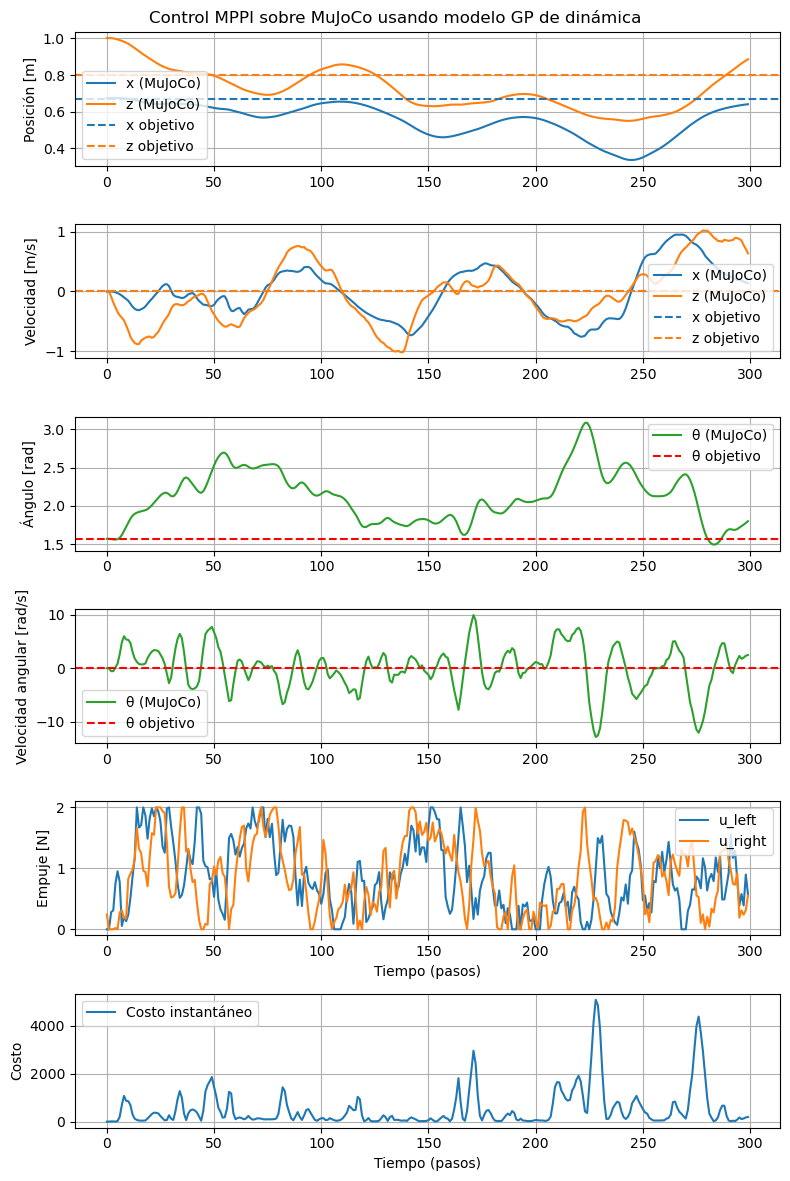

In [27]:
# =====================================================
# 5️⃣ Gráficos de estado / acción / costo
# =====================================================
fig, axes = plt.subplots(6, 1, figsize=(8, 12))

# 1) Posición x, z
axes[0].plot(traj_s[:,0], label="x (MuJoCo)", color='C0')
axes[0].plot(traj_s[:,1], label="z (MuJoCo)", color='C1')
axes[0].axhline(goal[0], color='C0', linestyle='--', label="x objetivo")
axes[0].axhline(goal[1], color='C1', linestyle='--', label="z objetivo")
axes[0].set_ylabel("Posición [m]")
axes[0].legend()
axes[0].grid()

# 1) Velocidad x, z
axes[1].plot(traj_s[:,2], label="x (MuJoCo)", color='C0')
axes[1].plot(traj_s[:,3], label="z (MuJoCo)", color='C1')
axes[1].axhline(goal[2], color='C0', linestyle='--', label="x objetivo")
axes[1].axhline(goal[3], color='C1', linestyle='--', label="z objetivo")
axes[1].set_ylabel("Velocidad [m/s]")
axes[1].legend(loc='lower right')
axes[1].grid()

# 2) Ángulo θ
axes[2].plot(traj_s[:,4], label="θ (MuJoCo)", color='C2')
axes[2].axhline(goal[4], color='r', linestyle='--', label="θ objetivo")
axes[2].set_ylabel("Ángulo [rad]")
axes[2].legend()
axes[2].grid()

# 2) Velocidad angular θ_dot
axes[3].plot(traj_s[:,5], label="θ (MuJoCo)", color='C2')
axes[3].axhline(goal[5], color='r', linestyle='--', label="θ objetivo")
axes[3].set_ylabel("Velocidad angular [rad/s]")
axes[3].legend()
axes[3].grid()

# 3) Acciones (empujes)
axes[4].plot(traj_u[:,0], label="u_left")
axes[4].plot(traj_u[:,1], label="u_right")
axes[4].set_ylabel("Empuje [N]")
axes[4].set_xlabel("Tiempo (pasos)")
axes[4].legend()
axes[4].grid()

# 4) Costo instantáneo
axes[5].plot(traj_cost, label="Costo instantáneo")
axes[5].set_ylabel("Costo")
axes[5].set_xlabel("Tiempo (pasos)")
axes[5].legend()
axes[5].grid()

plt.suptitle("Control MPPI sobre MuJoCo usando modelo GP de dinámica")
plt.tight_layout()
plt.show()


In [28]:
# =====================================================
# 6️⃣ Animación tipo Pendulum-v1 (si tienes frames)
# =====================================================
if len(frames) > 0:
    fig = plt.figure()
    img = plt.imshow(frames[0])

    renderer.close()  # cerrar el renderer de MuJoCo si no se necesita más

    def animate(i):
        img.set_data(frames[i])
        return [img]

    ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=30)
    plt.close()

    display(HTML(ani.to_html5_video()))

else:
    print("⚠️ No se capturaron frames. Añade tu función de render y apéndalos en 'frames'.")
